In [1]:
%gui qt
%matplotlib qt
from xmcd_projection import *
from glob import glob
import os
from skimage.io import imread, imsave
from PIL import Image

c:\users\lukas\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\lukas\miniconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\lukas\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Get file paths

In [2]:
msh_file = "example_mesh.msh"
mag_file = "mag_data.csv"

## Generate raytracing - skip if generated

In [3]:
# get the mesh
msh = Mesh.from_file(msh_file)

#### Make sure that the projection vector is correct and that the structure is oriented well

In [4]:
# get the projection vector
p = get_projection_vector(90, 16)

# prepare raytracing object
raytr = RayTracing(msh, p)
struct = raytr.struct
struct_projected = raytr.struct_projected

In [5]:
vis = MeshVisualizer(struct, struct_projected)
vis.set_camera(dist=2e5)
vis.show()

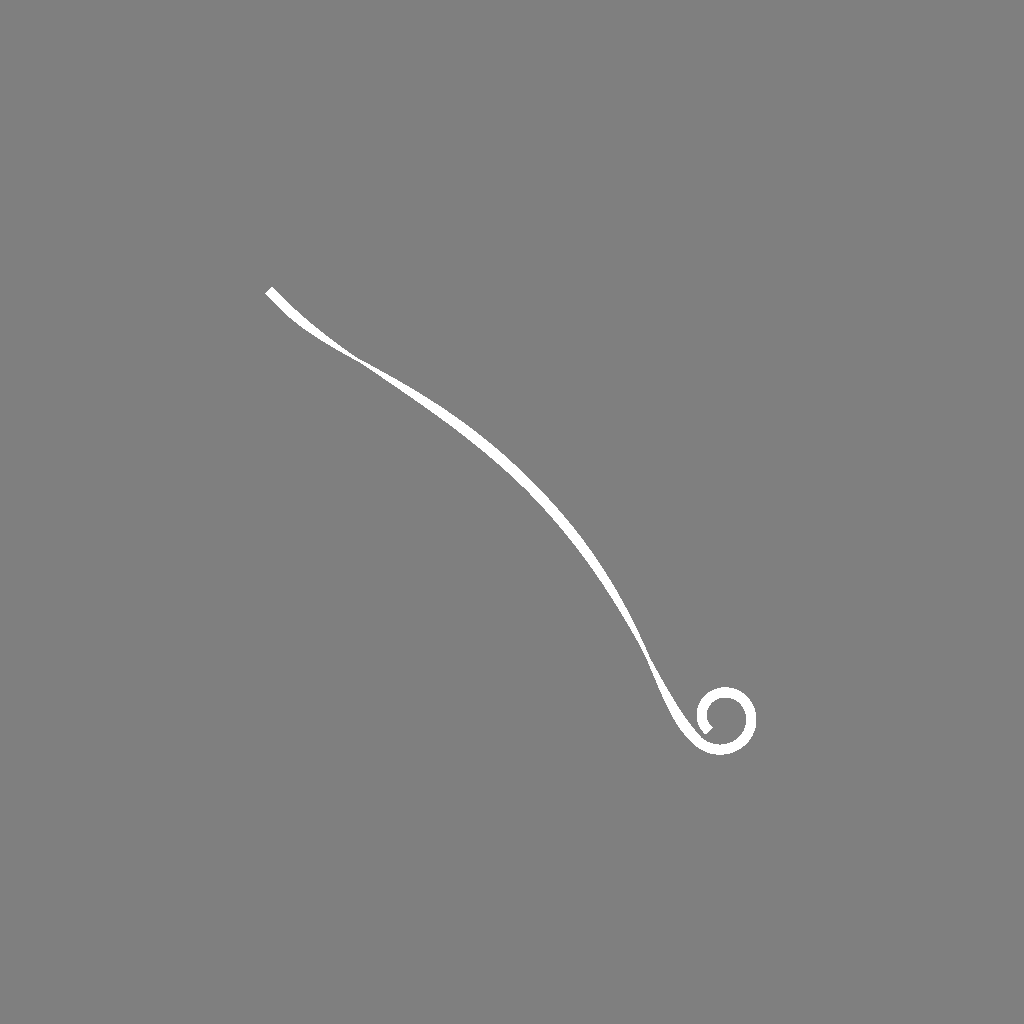

In [6]:
Image.fromarray(vis.get_image_np())

## If raytracing file generated - skip if not

In [7]:
# load raytracing if exists
raytr = np.load("raytracing.npy", allow_pickle=True).item()
struct = raytr.struct
struct_projected = raytr.struct_projected

## Generate and save raytracing

In [8]:
raytr.get_piercings()
np.save("raytracing.npy", raytr, allow_pickle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5490/5490 [00:06<00:00, 841.33it/s]


## Get the xmcd

#### Get magnetisation, fix vertex shuffling
Note: sometimes if the mesh file has multiple parts, the paraview export and the original mesh coordinates are not in the same order. I add a function to fix that when necessary

In [9]:
magnetisation, mag_points = load_mesh_magnetisation(mag_file)
shuffle_file = "shuffle_indx.npy"
try:
    shuffle_indx = np.load(shuffle_file)
except FileNotFoundError:
    print('File not found. Generating shuffle indx')
    shuffle_indx = msh.get_shuffle_indx(mag_points)
    np.save(shuffle_file, shuffle_indx)
magnetisation = magnetisation[shuffle_indx, :]

### Get the colours and XMCD values

In [10]:
xmcd_value = raytr.get_xmcd(magnetisation)
mag_colors = get_struct_face_mag_color(struct, magnetisation)

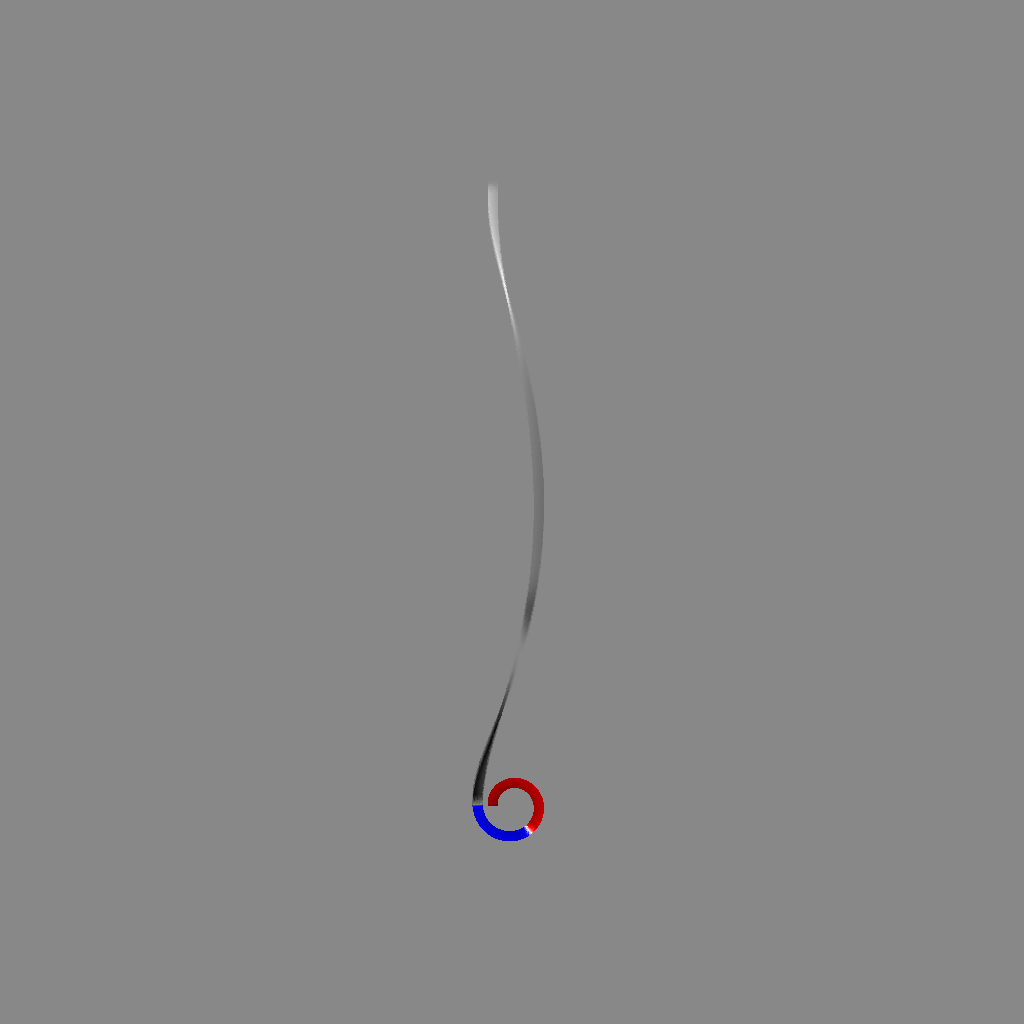

In [11]:
azi=90
center_struct = [0, 0, 0]
dist_struct = 2e4
center_peem = [0, -1000, 0]
dist_peem = 2e5

vis = MeshVisualizer(struct, struct_projected, projected_xmcd=xmcd_value, struct_colors=mag_colors)
vis.show(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### View different parts of the image separately

#### Both

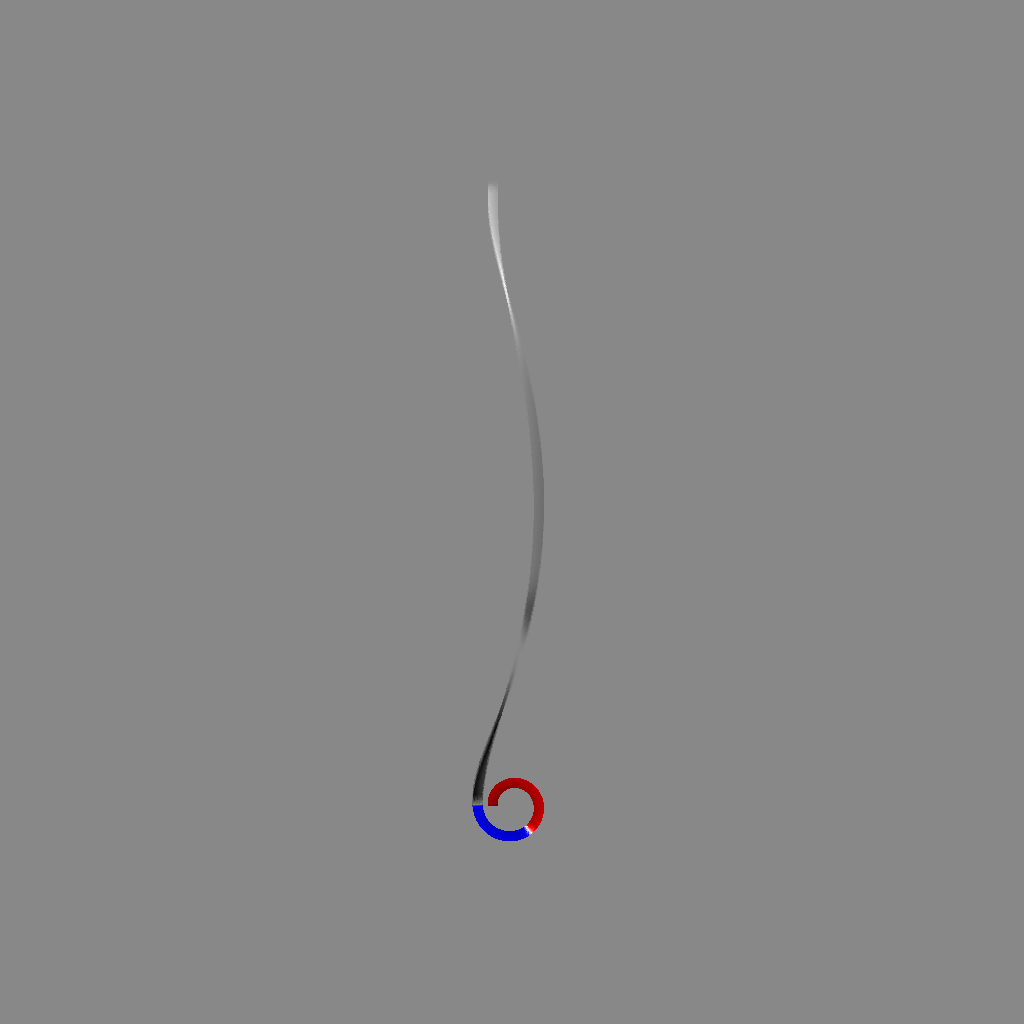

In [12]:
vis.update_colors(xmcd_value, mag_colors)
vis.view_both(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### Projection

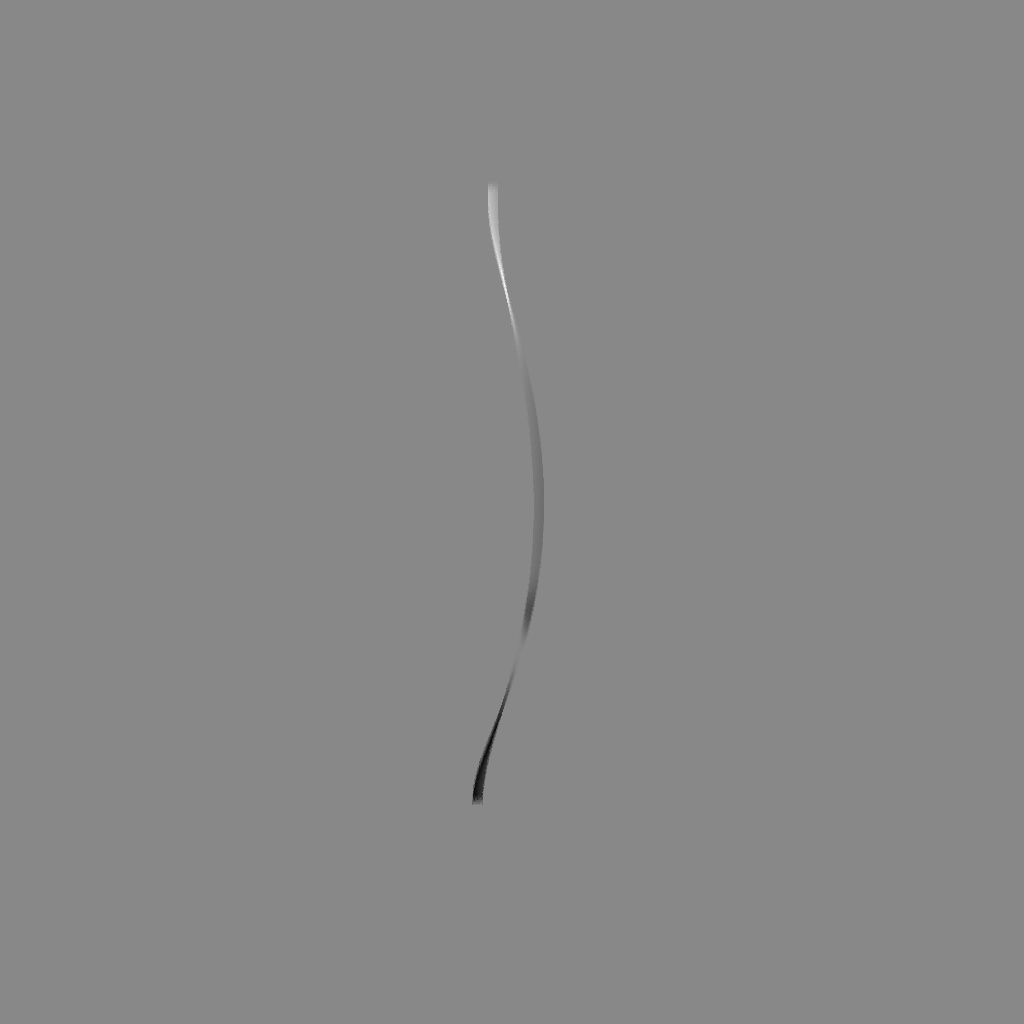

In [13]:
vis.view_projection(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray(vis.get_image_np())

#### Structure

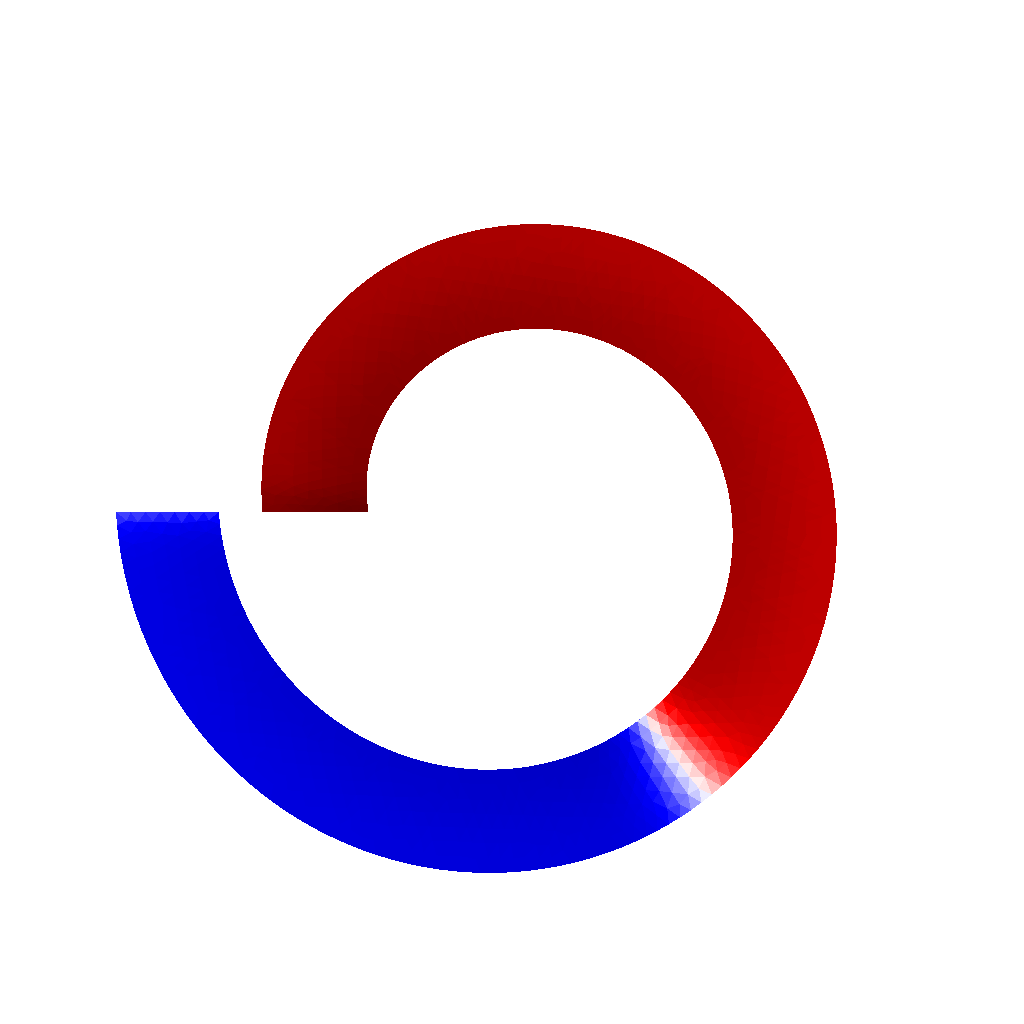

In [14]:
vis.view_struct(azi=azi, center=center_struct, dist=dist_struct)
Image.fromarray(vis.get_image_np())

#### Blurred image

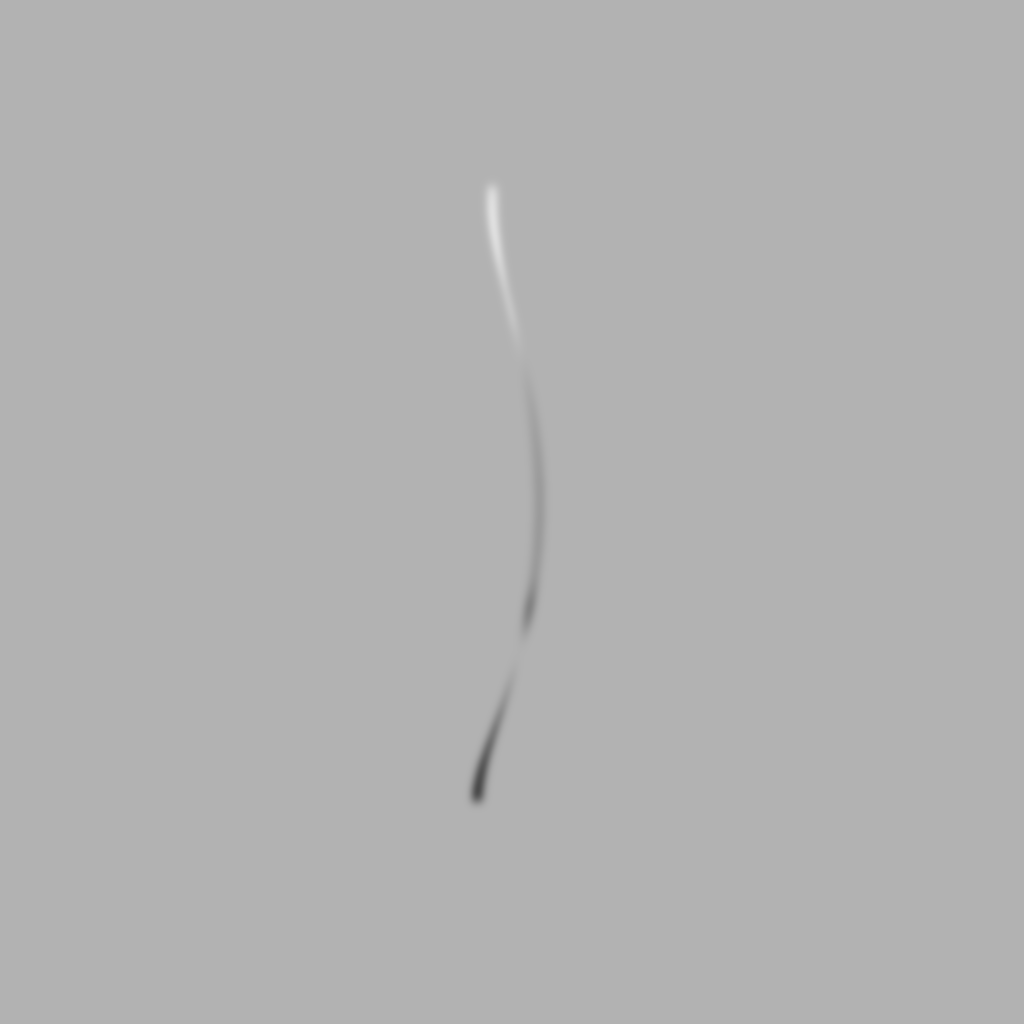

In [15]:
vis.view_projection(azi=azi, center=center_peem, dist=dist_peem)
Image.fromarray((vis.get_blurred_image(desired_background=0.7)*255).astype(np.uint8))

#### Saving one render

In [16]:
vis.view_both(azi=azi, center=center_peem, dist=dist_peem)
vis.save_render('shadow.png')
vis.view_projection()
blurred = vis.get_blurred_image(desired_background=0.7)
imsave('shadow_blurred.png', (blurred*255).astype(np.uint8), check_contrast=False)

vis.view_struct(azi=azi, center=center_struct, dist=dist_struct)
vis.save_render('structure_view.png')